# Examples 2.1 and 2.2 
From Parameter Estimation and Inverse Problems, 3rd edition, 2018  
by R. Aster, B. Borchers, C. Thurber  
ported to Python by J. MacCarthy

In [1]:
%reset -f

In [2]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

# show the figures in the Jupyter notebook
%matplotlib inline

Make sure we have a clean environment.

In [3]:
np.random.seed(0)

Load precomputed data.

In [4]:
matdata = loadmat('data1.mat', squeeze_me=True)

In [5]:
t, y, sigma = matdata['data1'].T
N = len(t)

Display t, y, sigma.

In [6]:
t, y, sigma

(array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]),
 array([ 109.3827,  187.5385,  267.5319,  331.8753,  386.0535,  428.4271,
         452.1644,  498.1461,  512.3499,  512.9753]),
 array([ 8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.]))

Build the parabolic system matrix.

In [7]:
G = np.array([np.ones_like(t), t, -0.5 * t**2]).T

Apply the weighting.  
*Note*: in the second operation, `sigma` is [broadcast](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) to match the dimensions of `G`. [`np.newaxis`](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#numpy.newaxis) adds an empty dimension to the vector, so that NumPy broadcasting rules work.

In [8]:
yw = y / sigma
Gw = G / sigma[:, np.newaxis]

Solve for the least-squares solution.

In [9]:
m = np.linalg.inv(Gw.T @ Gw) @ (Gw.T @ yw)

Get the covariance matrix

In [10]:
ginv = np.linalg.inv(Gw.T @ Gw) @ Gw.T
covm = ginv @ ginv.T
print(covm)

[[ 88.53333333 -33.6         -5.33333333]
 [-33.6         15.44242424   2.66666667]
 [ -5.33333333   2.66666667   0.48484848]]


Get the 1.96-sigma (95%) conf intervals.

In [11]:
del_ = 1.96 * np.sqrt(np.diag(covm))

print('95% parameter confidence intervals (m-, mest, m+)')
m - del_, m, m + del_

95% parameter confidence intervals (m-, mest, m+)


(array([ -2.02465374,  89.26547595,   8.04276678]),
 array([ 16.41740833,  96.96765856,   9.40753561]),
 array([  34.8594704 ,  104.66984117,   10.77230443]))

Because there are 3 parameters to estimate, we have `N-3` degrees of freedom.

In [12]:
dof = N - 3
chi2_ = np.linalg.norm((y - G @ m) / sigma)**2
print("The Chi-square misfit for {} degrees of freedom is {}.".format(dof, chi2_))

The Chi-square misfit for 7 degrees of freedom is 4.204836261879505.


Find the p-value for this data set.

In [13]:
from scipy.stats import chi2

p = 1 - chi2.cdf(chi2_, dof)

print('chi-square p-value: {}'.format(p))

chi-square p-value: 0.7559051789602904


Find the parameter correlations.

In [14]:
s = np.sqrt(np.diag(covm))
r = covm / (s[:, np.newaxis] * s.T)
print('correlation matrix')
r

correlation matrix


array([[ 1.        , -0.90871591, -0.81403354],
       [-0.90871591,  1.        ,  0.97455863],
       [-0.81403354,  0.97455863,  1.        ]])

Plot the data and model predicted data.

Displaying Data and Model Fit (fig 1)


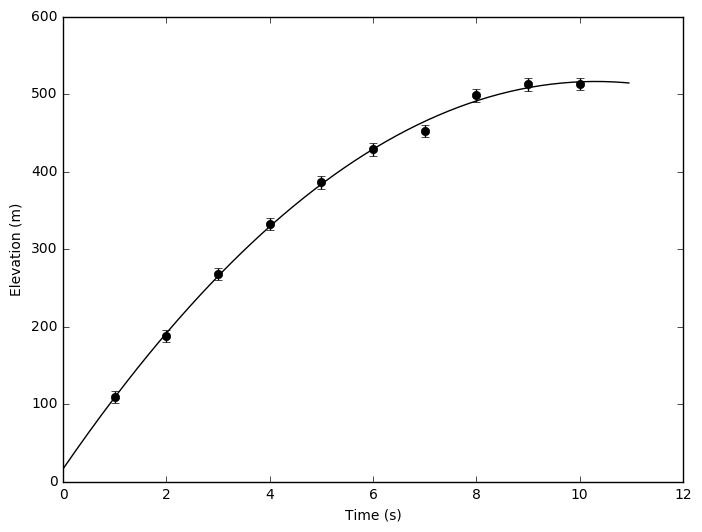

In [15]:
xx = np.arange(t.min() - 1, t.max() + 1, step=0.05)
mm = m[0] + m[1] * xx - 0.5 * m[2] * xx**2

plt.figure(1, figsize=(8,6))
plt.clf()
plt.plot(xx, mm, 'k')
plt.errorbar(t, y, yerr=sigma, fmt='ko')
plt.xlabel('Time (s)')
plt.ylabel('Elevation (m)')

print('Displaying Data and Model Fit (fig 1)')
plt.savefig('c2fparabfig.eps')

### Output covm and the eigenvalues/eigenvectors of covm.

Covariance matrix for fitted parameters.

In [16]:
covm

array([[ 88.53333333, -33.6       ,  -5.33333333],
       [-33.6       ,  15.44242424,   2.66666667],
       [ -5.33333333,   2.66666667,   0.48484848]])

Eigenvalues/eigenvectors of the covariance matrix  

In [17]:
lam, u = np.linalg.eig(np.linalg.inv(covm))

sorted_idx = np.argsort(lam)
lam = lam[sorted_idx]
u = u[:, sorted_idx]

u, lam

(array([[-0.92999841,  0.36634727, -0.02987694],
        [ 0.36289378,  0.90222923, -0.23300328],
        [ 0.05840426,  0.22753483,  0.97201689]]),
 array([  9.80591233e-03,   4.04569371e-01,   1.04714531e+02]))

*Note: The eigenvalues and vectors aren't necessarily in the same order as in MATLAB.  The outputs of `np.eig` are reversed from MATLAB's `eig`.  `lam` is a vector, not a diagonal matrix, as in MATLAB. The signs on the eigenvectors may be reversed.*

95% confidence ellipsoid semiaxis lengths

In [18]:
semi_axes = np.sqrt(chi2.ppf(0.95, 3) * (1 / lam))

95% confidence ellipsoid semiaxes

In [19]:
np.array([semi_axes[0] * u[:, 0], semi_axes[1] * u[:, 1], semi_axes[2] * u[:, 2]]).T

array([[ -2.62539790e+01,   1.61010201e+00,  -8.16186875e-03],
       [  1.02445398e+01,   3.96531161e+00,  -6.36525026e-02],
       [  1.64876015e+00,   1.00001917e+00,   2.65538359e-01]])

## Monte Carlo Section

In [20]:
y0 = G @ m

In [21]:
np.random.seed(0)
mmc = np.empty((1000, G.shape[1]))
chimc = np.empty(1000)

for nreal in range(1000):
  # Generate a trial data set of perturbed, weighted data
  ytrial = y0 + sigma * np.random.randn(N)
  ywtrial = ytrial / sigma
  mmc[nreal], *_ = np.linalg.lstsq(Gw, ywtrial)
  chimc[nreal] = np.linalg.norm(((G @ mmc[nreal]) - ytrial) / sigma)**2

Plot the histogram of chi squared values
Displaying 1000 Monte-Carlo Chi-square Values (fig 2)

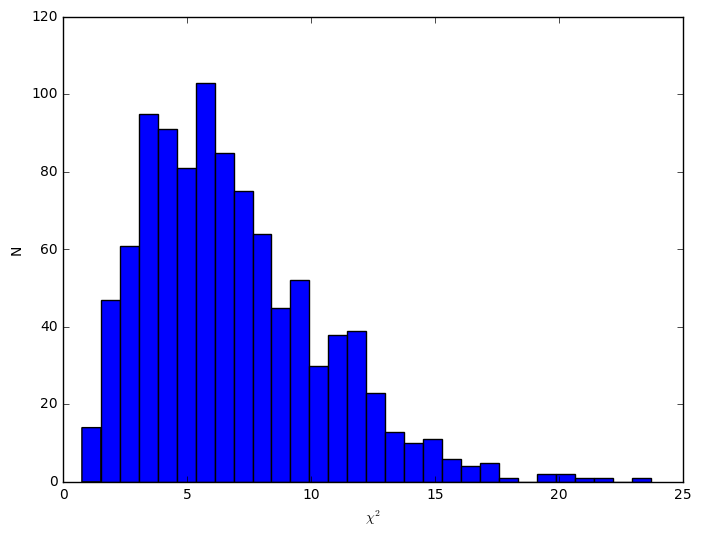

In [22]:
plt.figure(2, figsize=(8,6))
plt.clf()
plt.hist(chimc, 30)
plt.ylabel('N')
plt.xlabel('$\chi^2$')

Plot the histograms of the model parameters
Displaying Monte-Carlo Model Histograms (fig 3)

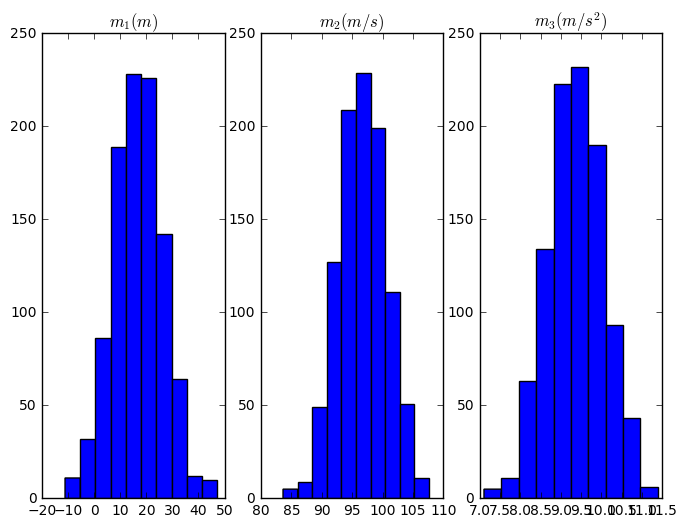

In [23]:
plt.figure(3, figsize=(8,6))
plt.clf()

plt.subplot(1,3,1)
plt.hist(mmc[:,0])
plt.title('$m_1 (m)$')

plt.subplot(1,3,2)
plt.hist(mmc[:,1])
plt.title('$m_2 (m/s)$')

plt.subplot(1,3,3)
plt.hist(mmc[:,2])
plt.title('$m_3 (m/s^2)$')

plt.subplots_adjust()

Plot the realizations of each pair of model parameters with the other
Displaying Projections of 1000 Monte-Carlo models (fig 4)

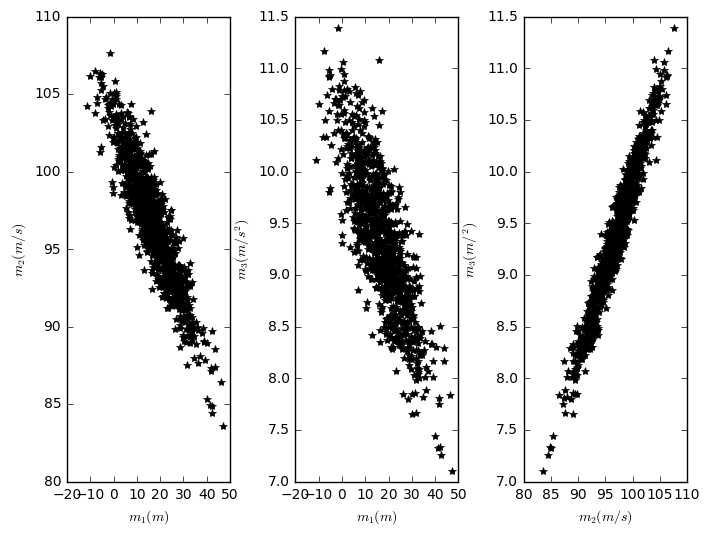

In [24]:
plt.figure(4, figsize=(8,6))
plt.clf()

plt.subplot(1,3,1)
plt.plot(mmc[:,0], mmc[:,1], 'k*')
plt.xlabel('$m_1 (m)$')
plt.ylabel('$m_2 (m/s)$')

plt.subplot(1,3,2)
plt.plot(mmc[:,0], mmc[:,2], 'k*')
plt.xlabel('$m_1 (m)$')
plt.ylabel('$m_3 (m/s^2)$')

plt.subplot(1,3,3)
plt.plot(mmc[:,1], mmc[:,2], 'k*')
plt.xlabel('$m_2 (m/s)$')
plt.ylabel('$m_3 (m/^2)$')

plt.subplots_adjust(wspace = 0.4)

Plot the 95% error ellipses for each pair of parameters
Note that because we're doing pairs of parameters there are 2
degrees of freedom in the Chi-square here, rather than 3.

In [25]:
# generate a vector of angles from 0 to 2*pi
theta = np.arange(0, 2*np.pi, 0.01)
delta = np.sqrt(chi2.ppf(0.95, 2))

# the radii in each direction from the center
r = np.zeros((len(theta), 2))

Displaying 95% Confidence Ellipse Projections (fig 5)


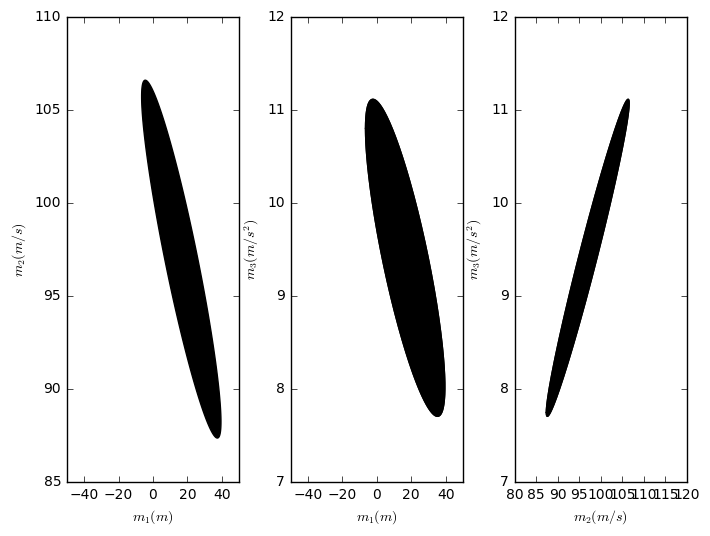

In [26]:
plt.figure(5, figsize=(8,6))
plt.clf()

# compute the data for the m1, m2 ellipsoid.
C = covm[0:2, 0:2]
lam, u = np.linalg.eig(np.linalg.inv(C))

# calculate the x component of the ellipsoid for all angles
r[:,0] = (delta / np.sqrt(lam[0])) * u[0,0] * np.cos(theta) \
       + (delta / np.sqrt(lam[1])) * u[0,1] * np.sin(theta)

# calculate the y component of the ellipsoid for all angles
r[:,1] = (delta / np.sqrt(lam[0])) * u[1,0] * np.cos(theta) \
       + (delta / np.sqrt(lam[1])) * u[1,1] * np.sin(theta)

# plot the data for the m1, m2 ellipsoid
plt.subplot(1,3,1)
plt.plot(m[1] + r[:,0], m[1] + r[:,1], 'k')
plt.fill(m[0] + r[:,0], m[1] + r[:,1], 'k')
plt.axis([-50, 50, 85, 110])
plt.xlabel('$m_1 (m)$')
plt.ylabel('$m_2 (m/s)$')

# compute the data for the m1, m3 ellipsoid.
C = covm[np.ix_([0,2],[0,2])]
lam, u = np.linalg.eig(np.linalg.inv(C))
deltachisq = chi2.ppf(0.95, 2)
delta = np.sqrt(deltachisq)
# calculate the x component of the ellipsoid for all angles
r[:,0] = (delta / np.sqrt(lam[0])) * u[0,0] * np.cos(theta) \
         + (delta / np.sqrt(lam[1])) * u[0,1] * np.sin(theta)
# calculate the y component of the ellipsoid for all angles
r[:,1] = (delta / np.sqrt(lam[0])) * u[1,0] * np.cos(theta) \
         + (delta / np.sqrt(lam[1])) * u[1,1] * np.sin(theta)

# plot the data for the m1, m3 ellipsoid
plt.subplot(1,3,2)
plt.plot(m[0] + r[:,0], m[2] + r[:,1], 'k')
plt.fill(m[0] + r[:,0], m[2] + r[:,1], 'k')
plt.axis([-50, 50, 7, 12])
plt.xlabel('$m_1 (m)$')
plt.ylabel('$m_3 (m/s^2)$')

# compute the data for the m2, m3 ellipsoid.
C = covm[np.ix_([1,2], [1,2])]
lam, u = np.linalg.eig(np.linalg.inv(C))
deltachisq = chi2.ppf(0.95, 2)
delta = np.sqrt(deltachisq)
# calculate the x component of the ellipsoid for all angles
r[:,0] = (delta / np.sqrt(lam[0])) * u[0,0] * np.cos(theta) \
         + (delta / np.sqrt(lam[1])) * u[0,1] * np.sin(theta)
# calculate the y component of the ellipsoid for all angles
r[:,1] = (delta / np.sqrt(lam[0])) * u[1,0] * np.cos(theta) \
         + (delta / np.sqrt(lam[1])) * u[1,1] * np.sin(theta)

# plot the data for the m2, m3 ellipsoid
plt.subplot(1,3,3)
plt.plot(m[1] + r[:,0], m[2] + r[:,1], 'k')
plt.fill(m[1] + r[:,0], m[2] + r[:,1], 'k')
plt.axis([80, 120, 7, 12])
plt.xlabel('$m_2 (m/s)$')
plt.ylabel('$m_3 (m/s^2)$')
plt.subplots_adjust(wspace = 0.3)

plt.savefig('c2fellipseproj.eps')

print('Displaying 95% Confidence Ellipse Projections (fig 5)')